In [1]:
from __future__ import print_function
from sklearn.metrics import roc_curve, auc
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

## Extract, train, infer
From the command line, run the following for each dataset (in this example we are working with the "english" subforum):

```
python run.py --name="english" --location="some/path" --cqadup-path="path/to/cqadup/zip/files" extract-dataset
python run.py --name="english" --location="some/path" extract-train-set
python run.py --name="english" --location="some/path" extract-test-set
python run.py --name="english" --location="some/path" extract-doc-text
python run.py --name="english" --location="some/path" train-model
python run.py --name="english" --location="some/path" infer-doc-vectors
```
The rest of this notebook assumes all of these commands were run and the location of the extracted files, trained vectors etc is "../data/cqadupstack", relative to this notebook's location.

In [2]:
name = "english"
location = "../data/cqadupstack/"

# Create an array of the learned vectors
vectors = []
with open("%s/%s/%s_vectors.txt" %(location, name, name), "rb") as f:
    for line in f:
        vectors.append(line.strip().split(" ")) 
vectors = np.array(vectors, dtype=float)

# Read the small training set of document pairs - there will be roughly
# 300 pairs that are duplicates and 3000 that are not.
train_pairs = []
with open("%s/%s/%s_trainpairs_tiny.txt" %(location, name, name)) as f:
    for line in f:
        train_pairs.append(line.strip().split(" "))

In [3]:
# We need our stored mapping of doc ids to indices, i.e. where each doc is
# in our vectors array
pkl_map_file = open("%s/%s/%s_mapping.pkl" %(location, name, name), 'rb')
key_mappings = pickle.load(pkl_map_file)
pkl_map_file.close()

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
scored_pairs_train = []
for i,p in enumerate(train_pairs):
    first,second,is_dup = p
    first_idx = key_mappings[first]
    first_vector = vectors[first_idx,:]
    second_idx = key_mappings[second]
    second_vector = vectors[second_idx,:]
    sim = cosine_similarity(first_vector.reshape(1, -1), second_vector.reshape(1, -1))
    scored_pairs_train.append([first,second,int(is_dup), sim[0,0]])

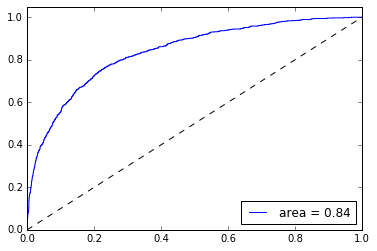

In [5]:
scores_arr_train = np.array(scored_pairs_train)
y_test = np.array(scores_arr_train[:,2], dtype=int)
y_pred = np.array(scores_arr_train[:,3], dtype=float)

fpr,tpr,_ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()

In [6]:
scored_pairs_train = sorted(scored_pairs_train, key = lambda x: x[3], reverse=True)
with open("%s/%s/%s_docs.txt" %(location, name, name), 'rb') as f:
    doc_text = f.readlines()
vectors_to_plot = {}
docs_to_plot = {}
pairs_list = []
for pair in scored_pairs_train[0:20]:
    pairs_list.append([pair[0], pair[1]])
    for i in [pair[0], pair[1]]:
        if not i in vectors_to_plot:
            vectors_to_plot[i] = vectors[key_mappings[i]]
            docs_to_plot[i] = doc_text[key_mappings[i]]
vector_keys_arr = np.array(vectors_to_plot.keys())
vector_keys_map = {v:k for k,v in enumerate(vector_keys_arr)}
dups = [[vector_keys_map[x], vector_keys_map[y]] for [x, y] in pairs_list]

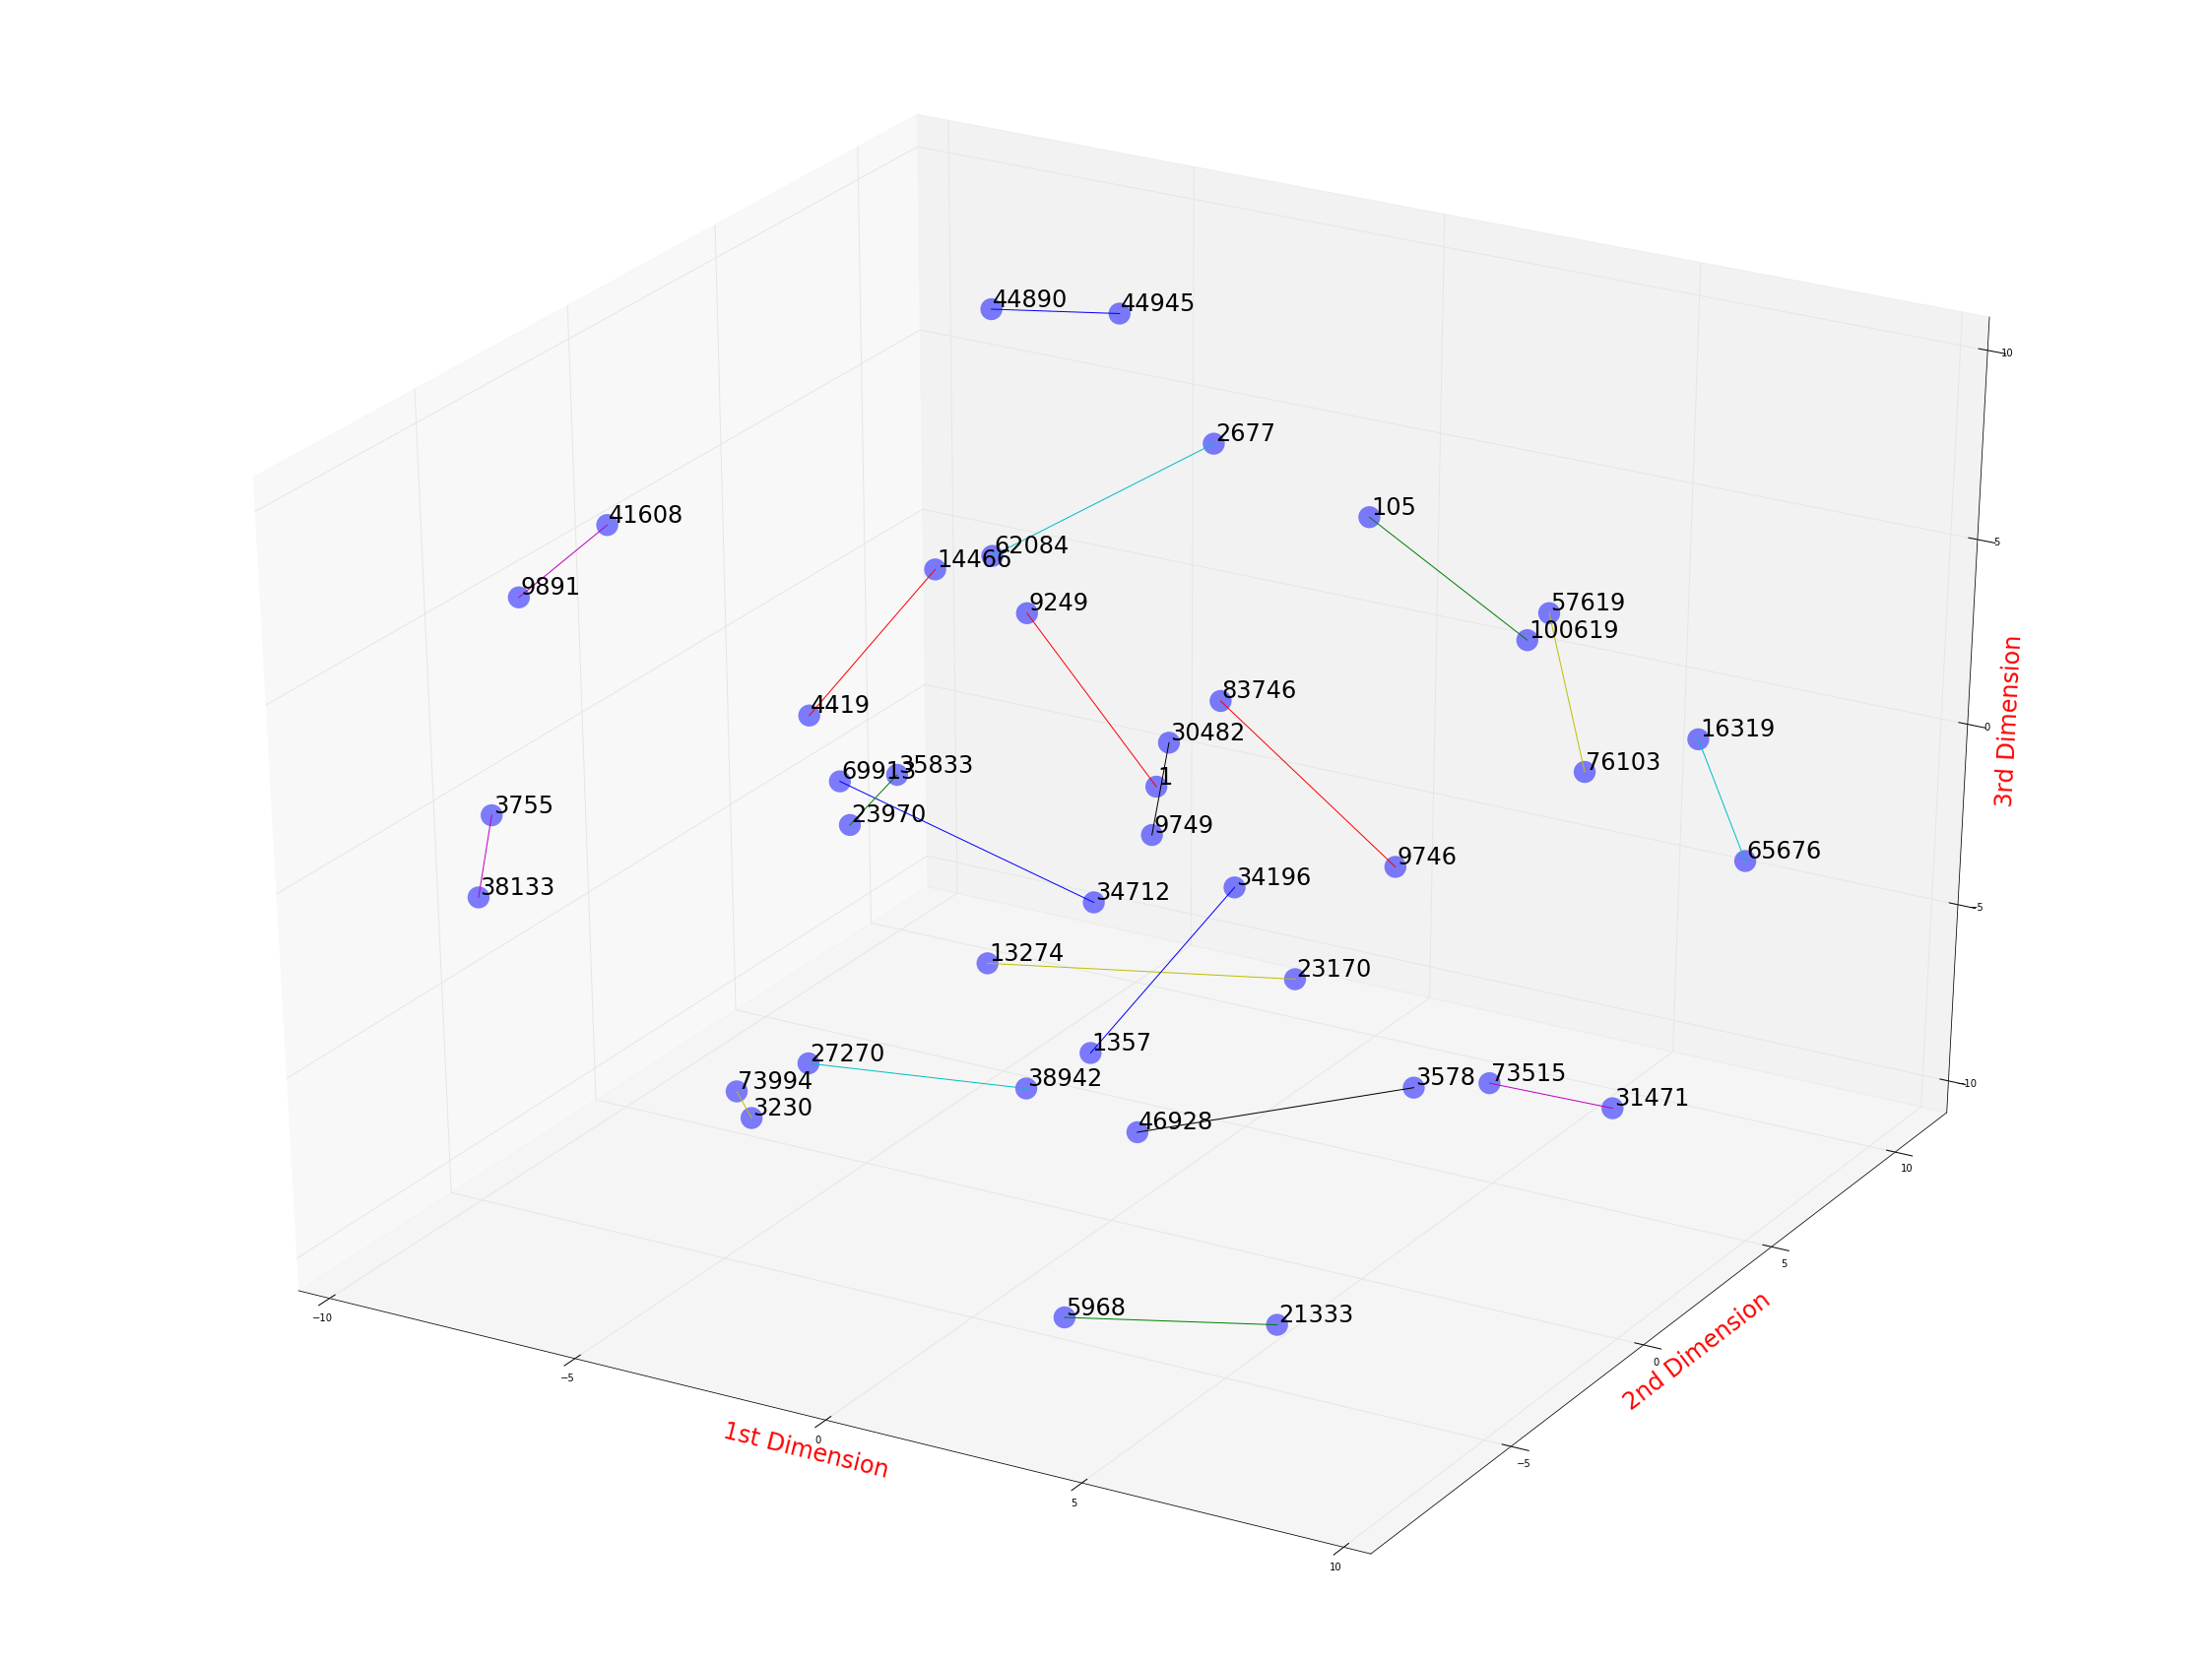

In [7]:
vectors_arr = np.asarray(vectors_to_plot.values()).astype('float64')
tsne_model_3d = TSNE(n_components=3, n_iter=100000, metric="correlation", learning_rate=50, 
                     early_exaggeration=500.0, perplexity=20.0, random_state=0)
reduced_3d = tsne_model_3d.fit_transform(vectors_arr)

plot_kwds = {'alpha' : 0.5, 's' : 500, 'linewidths': 0}
fig = plt.figure(figsize=(40, 30))
ax = fig.add_subplot(111, projection='3d')
x_vals = reduced_3d.T[0]
y_vals = reduced_3d.T[1]
z_vals = reduced_3d.T[2]
ax.scatter(x_vals, y_vals, z_vals,**plot_kwds)
ax.set_xlabel('1st Dimension', fontsize=24, color='r')
ax.set_ylabel('2nd Dimension', fontsize=24, color='r')
ax.set_zlabel('3rd Dimension', fontsize=24, color='r')
ax.set_xticks([], minor=True)

ax.set_xlim3d(min(x_vals) + 0.5, max(x_vals) - 0.3)
ax.set_ylim3d(min(y_vals) + 0.5, max(y_vals) - 0.5)    
ax.set_zlim3d(min(z_vals) + 0.5, max(z_vals) - 0.5)

plotted_texts = []
for i,k in enumerate(vector_keys_arr):
        plotted_texts.append(docs_to_plot[k].decode("utf8"))
        ax.text(x_vals[i],y_vals[i]+0.05,z_vals[i]+0.05,  k, size=24, color='k')
for dup in dups:
    ax.plot([x_vals[dup[0]],x_vals[dup[1]]], [y_vals[dup[0]],y_vals[dup[1]]], [z_vals[dup[0]],z_vals[dup[1]]]);